<a href="https://colab.research.google.com/github/shatakshii25/Machine-Learning-Projects/blob/main/DimensionalityReduction%26VisualizationUsingAutoEncoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###<h1><center>CSE-1016 DEEP LEARNING (Embedded Lab)</center></h1>###  
###<h1><center>Work by - Shatakshi Shree (20BAI1314) under Professor Bharadwaja Kumar Sir</center></h1>### 
<center><h1> Dimensionality reduction & Visualization using AutoEncoders </h1></center>

In [1]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from tensorflow import keras

## Loading the data

We will load MNIST, but without labels because representation learning is **unsupervised**, or **self-supervised** which is the prefered term.

In [4]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
x_train = x_train / 255
x_test = x_test / 255

11490434/11490434 [==============================] - 0s 0us/step


## A simple autoencoder



In [5]:
encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(30, activation="relu"),
])

The decoder is the same, but in opposite order. Keras needs to know the input shape at this point. The input shape of the decoder is the shape of $z$, also called `zDim`.

In [6]:
decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="relu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

Stacking them for training:

In [8]:
stacked_autoencoder = keras.models.Sequential([encoder, decoder])

We use binary cross entropy loss instead of categorical cross entropy. The reason for that is because we are not classifying latent vectors to belong to a particular class, we do not even have classes, but rather are trying to predict whether a pixel should be activated or not.

In [9]:
stacked_autoencoder.compile(loss="binary_crossentropy",
                   optimizer='adam')

In [10]:
history = stacked_autoencoder.fit(x_train, x_train, epochs=10,
                                  validation_data=[x_test, x_test])

Epoch 1/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1438 - val_loss: 0.1076
Epoch 2/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1035 - val_loss: 0.0974
Epoch 3/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0970 - val_loss: 0.0938
Epoch 4/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0941 - val_loss: 0.0921
Epoch 5/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0922 - val_loss: 0.0901
Epoch 6/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0909 - val_loss: 0.0897
Epoch 7/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0900 - val_loss: 0.0887
Epoch 8/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0892 - val_loss: 0.0878
Epoch 9/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0886 - val_loss: 0.0873
Epoch 10/10
1875/1875 [==============================] - 11s 6ms/step - l

Autoencoder reconstructs images:

1/1 [==============================] - 0s 17ms/step


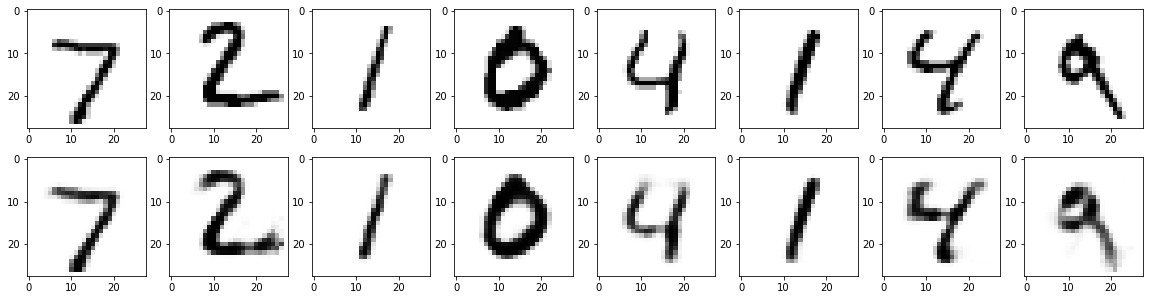

In [11]:
figsize(20, 5)
for i in range(8):
  subplot(2, 8, i+1)
  pred = stacked_autoencoder.predict(x_test[i].reshape((1, 28, 28)))
  imshow(x_test[i], cmap="binary")

  subplot(2, 8, i+8+1)
  imshow(pred.reshape((28, 28)), cmap="binary")

Just from this vector:


1/1 [==============================] - 0s 51ms/step


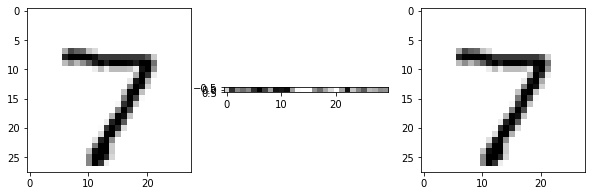

In [12]:
i = 0 # change this number

figsize(10, 5)

subplot(1, 3, 1)
imshow(x_test[i], cmap="binary")

subplot(1, 3, 2)
latent_vector = encoder.predict(x_test[i].reshape((1, 28, 28)))
imshow(latent_vector, cmap="binary")

subplot(1, 3, 3)
pred = decoder.predict(latent_vector)
imshow(x_test[i], cmap="binary")

In [13]:
30 / (28 * 28), 1 - 30 / (28 * 28)

(0.03826530612244898, 0.9617346938775511)

That's 96.2% compression! 

## Convolutional autoencoder

Apart from data compression, autoencoders can also be used for self-supervised image classification.

The first layers of the encoder learn to recognize patterns in the data very well in order to compress the data. If you don't have access to much labelled data, but a lot of unlabelled data, it's possible to train an autoencoder and copy the first layers from the autoencoder to the classifier network. This can be compared to transfer learning, where you only have to train the head afterwards.


Convolutional encoder:

In [14]:
encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2)
])

The weights learnt by this encoder could be copied to the classifier.

In [15]:
encoder.predict(x_test[0].reshape((1, 28, 28))).shape

1/1 [==============================] - 0s 110ms/step


(1, 3, 3, 64)

$z \in \mathbb{R}^{1 \times 3 \times 3 \times 64}$. Building its counterpart, the decoder, with transposed convolutional layers to recreate a grayscale $28 \times 28$ image.

In [16]:
decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=2, padding="valid",
                                 activation="relu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=(3, 3), strides=2, padding="same",
                                 activation="relu"),
    keras.layers.Conv2DTranspose(1, kernel_size=(3, 3), strides=2, padding="same",
                                 activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

In [17]:
stacked_autoencoder = keras.models.Sequential([encoder, decoder])

In [18]:
stacked_autoencoder.compile(loss="binary_crossentropy",
                            optimizer='adam')

In [19]:
history = stacked_autoencoder.fit(x_train, x_train, epochs=10,
                         validation_data=[x_test, x_test])

Epoch 1/10
1875/1875 [==============================] - 72s 38ms/step - loss: 0.1230 - val_loss: 0.0842
Epoch 2/10
1875/1875 [==============================] - 71s 38ms/step - loss: 0.0811 - val_loss: 0.0775
Epoch 3/10
1875/1875 [==============================] - 70s 38ms/step - loss: 0.0768 - val_loss: 0.0745
Epoch 4/10
1875/1875 [==============================] - 77s 41ms/step - loss: 0.0745 - val_loss: 0.0729
Epoch 5/10
1875/1875 [==============================] - 71s 38ms/step - loss: 0.0729 - val_loss: 0.0716
Epoch 6/10
1875/1875 [==============================] - 73s 39ms/step - loss: 0.0717 - val_loss: 0.0708
Epoch 7/10
1875/1875 [==============================] - 72s 38ms/step - loss: 0.0709 - val_loss: 0.0700
Epoch 8/10
1875/1875 [==============================] - 71s 38ms/step - loss: 0.0703 - val_loss: 0.0696
Epoch 9/10
1875/1875 [==============================] - 77s 41ms/step - loss: 0.0698 - val_loss: 0.0690
Epoch 10/10
1875/1875 [==============================] - 71s 38m

1/1 [==============================] - 0s 20ms/step


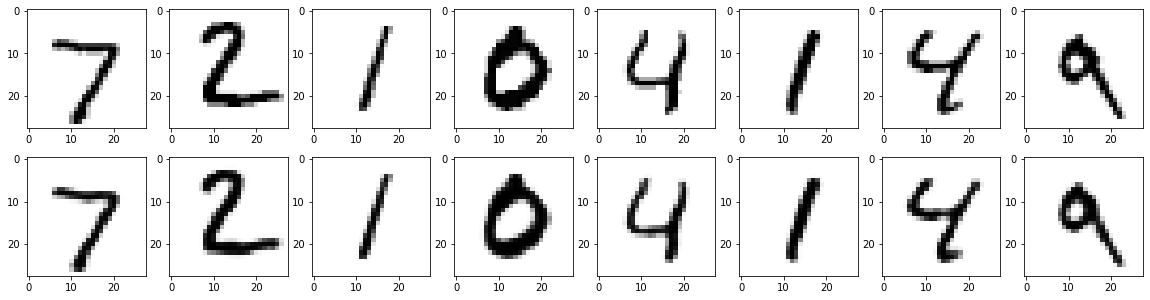

In [20]:
figsize(20, 5)
for i in range(8):
  subplot(2, 8, i+1)
  pred = stacked_autoencoder.predict(x_test[i].reshape((1, 28, 28)))
  imshow(x_test[i], cmap="binary")

  subplot(2, 8, i+8+1)
  imshow(pred.reshape((28, 28)), cmap="binary")

Weights the encoder learnt.

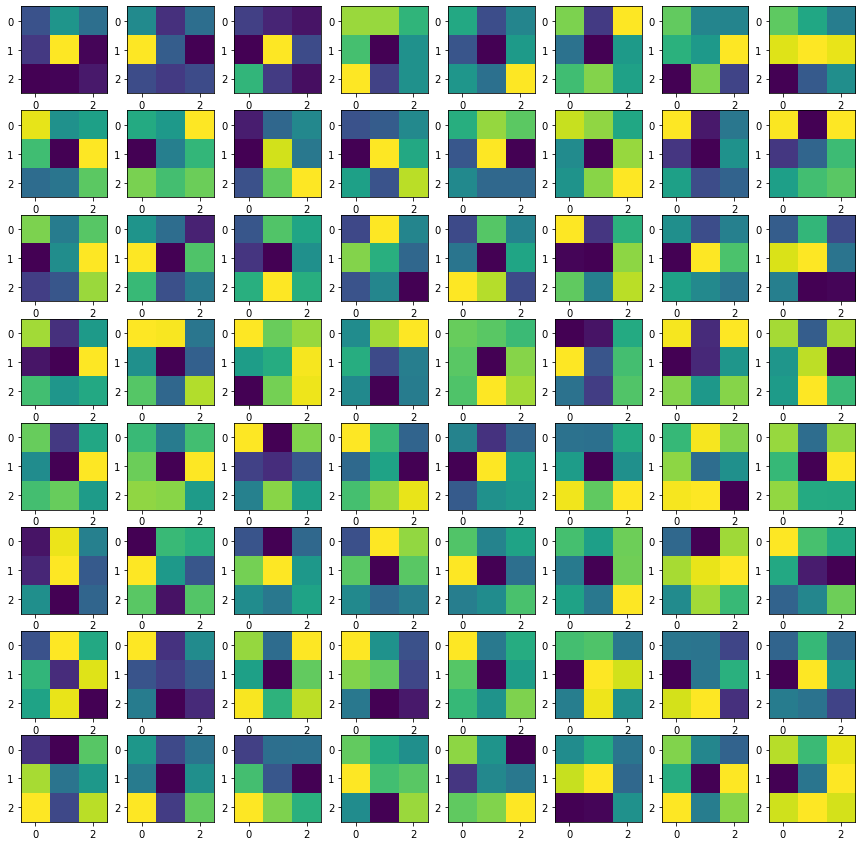

In [21]:
figsize(15, 15)
for i in range(8 * 8):
  subplot(8, 8, i+1)
  imshow(encoder.layers[-2].weights[0][:, :, 0, i])

$3 \times 3 \times 64=576$ is still less than $28 \times 28 = 784$, thus creating a bottleneck, but much less compressed than the dense encoder making convolutional encoders less suitable for comporession. 

## Denoising autoencoder

The last application of autoencoders are denoising autoencoders.

In [22]:
import numpy as np

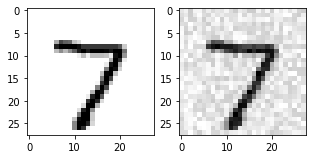

In [23]:
figsize(5, 10)
subplot(1, 2, 1)
imshow(x_test[0], cmap="binary")

subplot(1, 2, 2)
noise = np.random.random((28, 28)) / 4
imshow(x_test[0] + noise, cmap="binary")

Noise can be catasrophic

By applying noise to the images inputted to the encoder and setting the clean image as desired output, $y$, an autoencoder can learn to remove noise from the image.


In [24]:
encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(30, activation="relu")
])

In [25]:
decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="relu", input_shape=[30]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

In [26]:
stacked_autoencoder = keras.models.Sequential([encoder, decoder])

In [27]:
stacked_autoencoder.compile(loss="binary_crossentropy",
                            optimizer='adam')

Creating a dataset filled with noise:

In [28]:
x_train_noise = x_train + ((np.random.random(x_train.shape)) / 4)
x_test_noise = x_test + ((np.random.random(x_test.shape)) / 4)

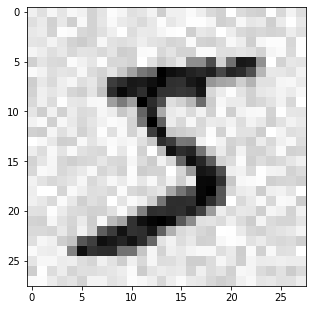

In [29]:
imshow(x_train_noise[0], cmap="binary")

Finally training the stacked autoencoder with noise input data and clean output data.

In [30]:
history = stacked_autoencoder.fit(x_train_noise, x_train, epochs=10,
                                  validation_data=[x_test_noise, x_test])

Epoch 1/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.1624 - val_loss: 0.1244
Epoch 2/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1187 - val_loss: 0.1124
Epoch 3/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1094 - val_loss: 0.1068
Epoch 4/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1039 - val_loss: 0.1007
Epoch 5/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1006 - val_loss: 0.0984
Epoch 6/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0984 - val_loss: 0.0964
Epoch 7/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0970 - val_loss: 0.0950
Epoch 8/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0958 - val_loss: 0.0948
Epoch 9/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0946 - val_loss: 0.0932
Epoch 10/10
1875/1875 [==============================] - 12s 6ms/step - l

1/1 [==============================] - 0s 17ms/step


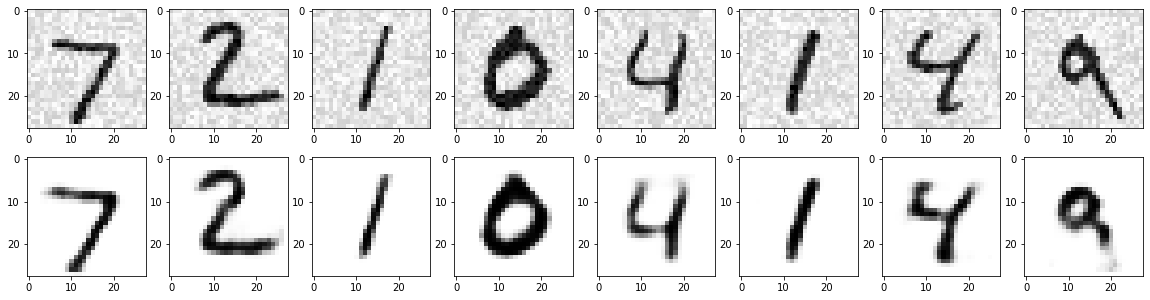

In [31]:
figsize(20, 5)
for i in range(8):
  subplot(2, 8, i+1)
  imshow(x_test_noise[i], cmap="binary")

  subplot(2, 8, i+8+1)
  pred = stacked_autoencoder.predict(x_test_noise[i].reshape((1, 28, 28)))
  imshow(pred.reshape((28, 28)), cmap="binary")